In [502]:
import numpy as np
import scipy.linalg as sc
import matplotlib.pyplot as plt
from scipy import signal

from MRPy import MRPy

## Introdução

Fase 01 - Modelo de 2 gdl sujeito a excitação harmônica  
Fase 02 - Amortecedor de massa ativo

## Fase 01 - Modelo de 2 gdl sujeito a excitação harmônica

## 1. Modelo

### 1.1 Parâmetros Iniciais

In [503]:
L  = 0.15
EI = 2.05e11*(0.02*0.0005**3)/12
k  = 12*EI/L/L/L

m1=0.4
m2=0.4

### 1.2 Matrizes de Rigidez e Massa (lumped)

In [504]:

# Stiffness coefficients in N/m
K = np.array ([[ 2*k, -2*k], 
               [-2*k,  4*k]])


# Lumped mass matrix in kg


M = np.array([ [m1,  0,], 
               [0,  m2,]])

print ("Matriz de rigidez\n",K)
print ("\nMatriz de Massa (lumped)\n",M)

Matriz de rigidez
 [[ 303.7037037  -303.7037037 ]
 [-303.7037037   607.40740741]]

Matriz de Massa (lumped)
 [[0.4 0. ]
 [0.  0.4]]


### 1.3 Cálculo das frequências e modos de vibrações

First vibration mode:   2.71Hz, [ 0.851  0.526]
Second vibration mode:  7.10Hz, [-0.526  0.851]


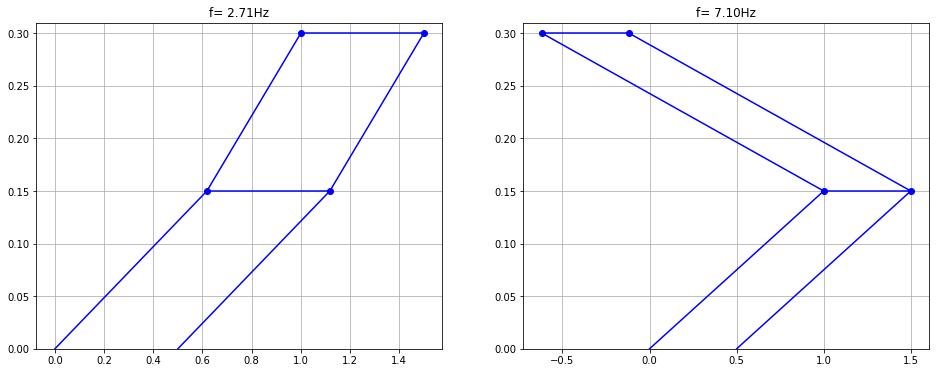

In [505]:
# Uses scipy to solve the standard eigenvalue problem
w2, Phi = sc.eig(K, M)

# Ensure ascending order of eigenvalues
iw  = w2.argsort()
w2  = w2[iw]
Phi = Phi[:,iw]

# Eigenvalues to vibration frequencies
wk  = np.sqrt(np.real(w2)) 
fk  = wk/2/np.pi

print('First vibration mode:  {0:5.2f}Hz, [{1:6.3f} {2:6.3f}]'.format(fk[0], *Phi[:,0]))
print('Second vibration mode: {0:5.2f}Hz, [{1:6.3f} {2:6.3f}]'.format(fk[1], *Phi[:,1]))

## Plotagem dos 3 primeiros modos de vibração da estrutura
plt.figure(1, figsize=(16,6))
x = np.linspace(0,2*L,3)

for k in range(2):
    pk = np.zeros(3)
    pk[1:] = Phi[::-1,k]
    pk /=np.max(np.abs(pk))
    plt.subplot(1,2,k+1)
    
    ## Linhas Horizontais
    for n in range(2):
        o = np.linspace(pk[n+1],pk[n+1]+.5,2)
        y1 = np.ones(2)*n*L+L
        plt.plot(o, y1, 'b')
    
    ## Pontos
    plt.plot(pk[1:],x[1:],'bo')
    plt.plot(pk[1:]+.5, x[1:], 'bo')
    
    ## Linhas Verticais
    plt.plot(pk,x,'b')
    plt.plot(pk+.5, x,'b')

#    plt.xlim(-1.5, 1.5); plt.ylabel("Altura [cm]");
    plt.ylim( 0.0, 2*L+.01);
    plt.title('f= {0:3.2f}Hz'.format(fk[k]));
    plt.grid(True)

In [506]:
Mk = np.diag(np.dot(Phi.T, np.dot(M, Phi)))

print('First mode modal mass is:  {0:7.2f}kg'.format(Mk[0]))
print('Second mode modal mass is: {0:7.2f}kg'.format(Mk[1]))

First mode modal mass is:     0.40kg
Second mode modal mass is:    0.40kg


## 2. Funcionamento do Motor de Passo

Lembretes:

1 ciclo = 4 passos  
1 revolução (imã) = 32 passos  
1 revolução (imã) = 8 ciclos  
Razão eixo imã-externo = 1/64  
1 revolução eixo externo = 512 ciclos


### 2.1 Relação Amplitude x Frequência

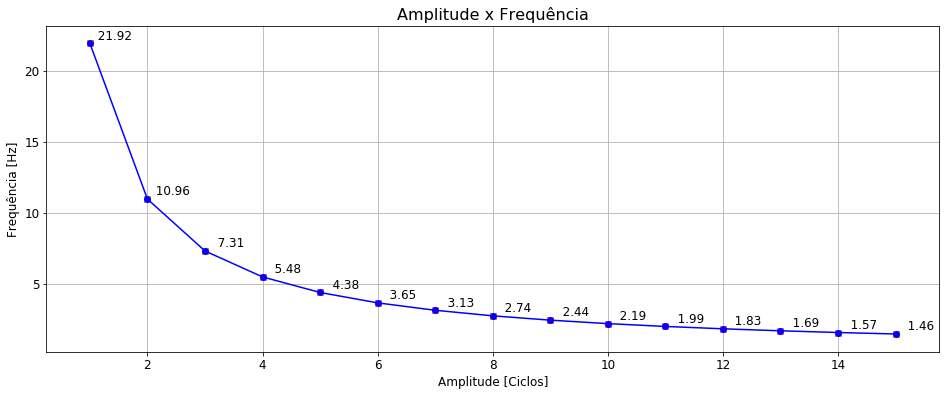

In [507]:
A=np.linspace(1,15,15)
ang = (2*np.pi/512)*A       # Amplitude do movimento [ângulo de giro]
lag_time = 0.0014258        # Tempo de atraso entre os passos
Tm = 4*A*8*lag_time         # Período do movimento
fm = 1/Tm                   # Frequência do movimento


plt.figure(2, figsize=(16,6))
plt.plot(A,fm, 'bo')
plt.plot(A,fm, 'b')
plt.title("Amplitude x Frequência", fontsize=16);
plt.xlabel("Amplitude [Ciclos]", fontsize=12)
plt.ylabel("Frequência [Hz]", fontsize=12)
plt.grid(True)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)


for i,type in enumerate(fm):
    plt.scatter(A[i], fm[i], marker='x', color='red')
    plt.text(A[i]+0.01, fm[i]+0.3, "{0:7.2f}".format(fm[i]), fontsize=12)
plt.show()

### 2.2 Definição de Parâmetros

In [508]:

A = 10                      # Amplitude do movimento [número de ciclos]
ang = (2*np.pi/512)*A       # Amplitude do movimento [ângulo de giro - rad]
L = .1                      # Comprimento da haste [m] 
D = ang*L                   # Amplitude em deslocamento horizontal [m]
lag_time = 0.0014258        # Tempo de atraso entre os passos
Tm = 4*A*8*lag_time         # Período do movimento
fm = 1/Tm                   # Frequência do movimento



print ("A aplitude do movimento é: {0:5.3f}rad".format(ang))
print ("A aplitude do movimento é: {0:5.3f}°".format(ang*180/np.pi))
print ("A aplitude do movimento é: {0:5.3f}m".format(D))
print ("O período do movimento é: {0:5.3f}s".format(Tm))
print ("A frequência do movimento é: {0:5.3f}Hz".format(fm))

A aplitude do movimento é: 0.123rad
A aplitude do movimento é: 7.031°
A aplitude do movimento é: 0.012m
O período do movimento é: 0.456s
A frequência do movimento é: 2.192Hz


## 3. Excitação Harmônica

In [517]:
## Geração de sinal triangular

# Discretização do tempo
N = 42100
Td =  N*lag_time
t=np.linspace(0,Td,N+1)
fs =  N/Td
zt=0.01

triangle = signal.sawtooth(2*np.pi*fm*t, 0.5)
u=triangle*D                # Amplitude em Deslocamento [m] 
u=u[80:]
t=t[:-80]

v=np.diff(u, n=1)
a=np.diff(u, n=2)

O deslocamento horizontal da massa é representado por uma função triangular. Aplicando a derivada duas vezes nessa função encontramos os valores de velocidade e aceleração do corpo.

Text(0, 0.5, 'Aceleração (m/s²)')

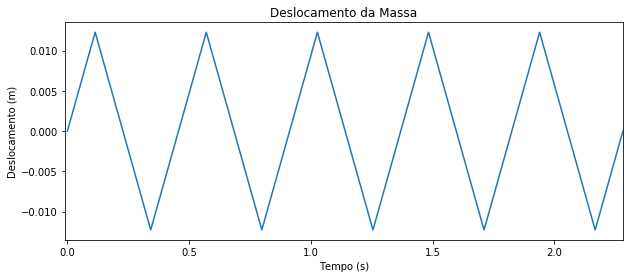

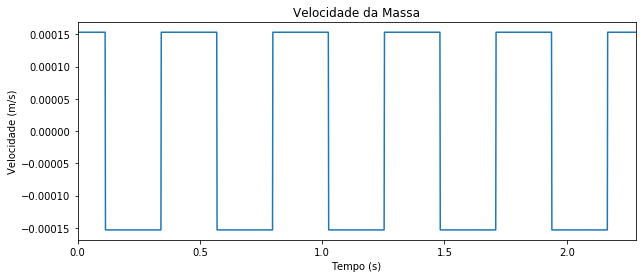

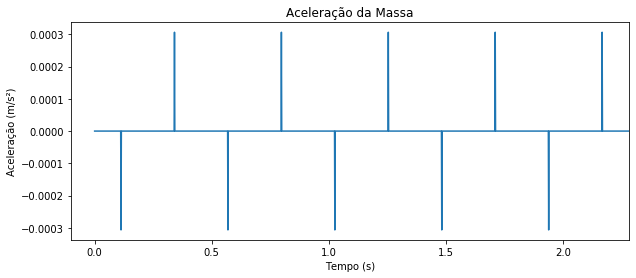

In [522]:
plt.figure(2, figsize=(10, 4), clear=True)
plt.plot(t, u)
plt.title("Deslocamento da Massa", )
plt.xlim(-.01, 5*Tm);   plt.xlabel('Tempo (s)') 
plt.ylabel('Deslocamento (m)')

plt.figure(3, figsize=(10, 4), clear=True)
plt.plot(t[:-1], v)
plt.title("Velocidade da Massa")
plt.xlim(0, 5*Tm);
plt.xlabel('Tempo (s)'); plt.ylabel('Velocidade (m/s)')

plt.figure(4, figsize=(10, 4), clear=True)
plt.plot(t[:-2],a)
plt.title("Aceleração da Massa")
plt.xlim(-.1, 5*Tm);
plt.xlabel('Tempo (s)'); plt.ylabel('Aceleração (m/s²)')

R.M.S. displacement of system mass: 0.0000m
R.M.S. displacement of damper:      0.0000m


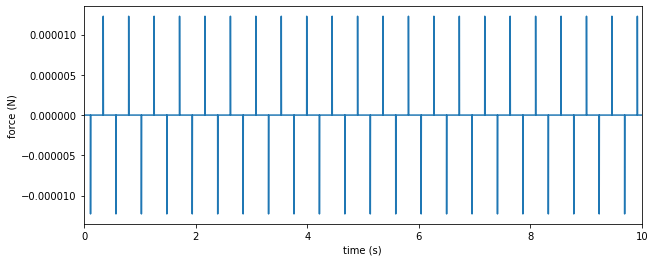

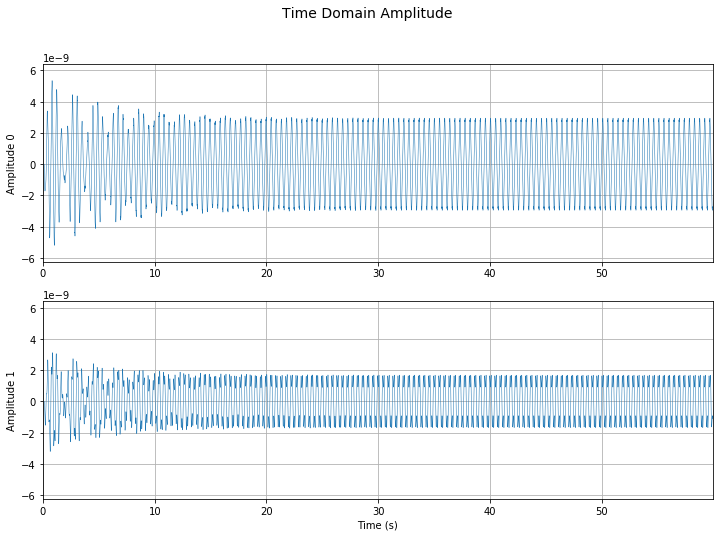

In [529]:
# Excitation properties
m=0.1*m1
F1 =  m*a                             # Intensity            
F  = [F1, np.zeros(t[:-2].shape)]     # loading vector

# Modal force as MRPy object
Fk =  MRPy(np.dot(Phi.T, F), fs=fs)

# Normalize by modal masses:
for k in range(2):
    Fk[k,:] /= Mk[k]
    
uk =  Fk.sdof_Duhamel(fk, zt)           # solve by Duhamel
ut =  MRPy(np.dot(Phi, uk), fs=uk.fs)   # back from modal space

    
plt.figure(5, figsize=(10, 4), clear=True)
plt.plot(t[:-2],F[0])    
plt.xlim(-.01, 10);   plt.xlabel('time (s)') 
plt.ylabel('force (N)')


ut.plot_time();


print('R.M.S. displacement of system mass: {0:6.4f}m'.format(ut[0].std()))
print('R.M.S. displacement of damper:      {0:6.4f}m'.format(ut[1].std())) 